In [340]:
import pandas as pd
import pint_pandas
import logging
import tinarm
import os
import numpy as np
from matplotlib import pyplot as plt

In [45]:
### Configure Logging
LOGGING_LEVEL = logging.INFO

logger = logging.getLogger()
logger.setLevel(LOGGING_LEVEL)
logger.info(f"tinarm version {tinarm.__version__}")
logger.info(f"pint_pandas version {pint_pandas.__version__}")

q = pint_pandas.PintType.ureg
q.setup_matplotlib()

2024-02-11 00:18:21,946 - NoJobId - INFO - Martins-MacBook-Air.local - 194884122.py-><module>() - tinarm version 0.1
2024-02-11 00:18:21,947 - NoJobId - INFO - Martins-MacBook-Air.local - 194884122.py-><module>() - pint_pandas version 0.5


In [46]:
operating_points = [op_point for op_point in os.listdir('M2') if os.path.isdir(os.path.join('m2',op_point))]

In [47]:
operating_points

['Nominal_46Nm_2420rpm',
 'PeakPowerMaxSpeed_31Nm_3300rpm',
 'NominalPowerMaxSpeed_30Nm_3300rpm',
 'PeakTorqueBaseSpeed_69Nm_1610rpm']

In [347]:
for op_point in operating_points:
    print(f"Processing {op_point}")
    chart = [c for c in os.listdir(os.path.join('M2',op_point)) if c.endswith('.csv')]
    chart.sort()
    print(chart)

Processing Nominal_46Nm_2420rpm
['BackEmf.csv', 'CurrentAngle.csv', 'IronLoss.csv', 'MagnetLoss.csv', 'PhaseVoltage.csv', 'Torque.csv']
Processing PeakPowerMaxSpeed_31Nm_3300rpm
['BackEmf.csv', 'CurrentAngle.csv', 'IronLoss.csv', 'MagnetLoss.csv', 'PhaseVoltage.csv', 'Torque.csv']
Processing NominalPowerMaxSpeed_30Nm_3300rpm
['BackEmf.csv', 'CurrentAngle.csv', 'IronLoss.csv', 'MagnetLoss.csv', 'PhaseVoltage.csv', 'Torque.csv']
Processing PeakTorqueBaseSpeed_69Nm_1610rpm
['BackEmf.csv', 'CurrentAngle.csv', 'IronLoss.csv', 'MagnetLoss.csv', 'PhaseVoltage.csv', 'Torque.csv']


In [348]:
expected_charts = ['BackEmf.csv', 'CurrentAngle.csv',
                   'IronLoss.csv', 'MagnetLoss.csv',
                   'PhaseVoltage.csv', 'Torque.csv']


In [349]:
df = pd.read_csv(os.path.join('M2', op_point, expected_charts[0]), index_col=None, header=[0,1])

In [392]:
theta_e = np.hstack((np.deg2rad(df['EMFa']['X'] ),
          np.deg2rad((df['EMFb']['X']-24) ),
          np.deg2rad((df['EMFc']['X']+24) )))


In [393]:

v_emf = np.hstack((df['EMFa']['Y'],
            df['EMFb']['Y'],
            df['EMFc']['Y']))


   

In [394]:
not_nan  = np.logical_not(np.logical_and(np.isnan(theta_e), np.isnan(v_emf)))
theta_e = theta_e[not_nan]
v_emf = v_emf[not_nan]
sort_idx = np.argsort(theta_e)

In [395]:
np.pi/5

0.6283185307179586

In [396]:
import scipy.signal as signal
w = np.logspace(-1,3,100)
pgram = signal.lombscargle(theta_e[sort_idx], v_emf[sort_idx], normalize=False).

Text(0, 0.5, 'Normalized amplitude')

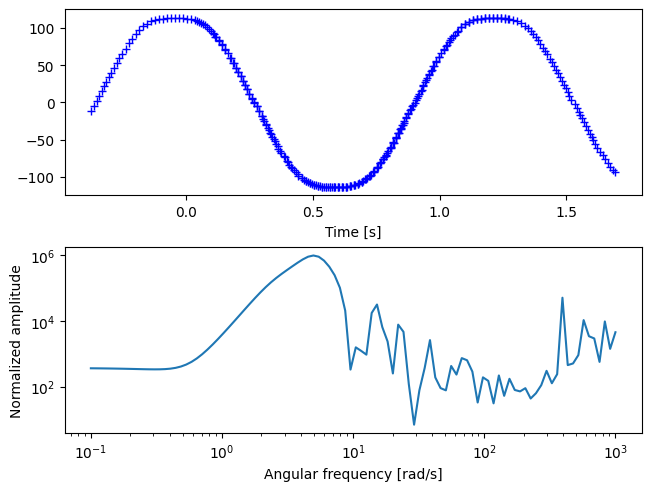

In [397]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(theta_e[sort_idx], v_emf[sort_idx], 'b+')
ax_t.set_xlabel('Time [s]')
ax_w.plot(w, pgram)
ax_w.set_xscale('log')
ax_w.set_yscale('log')
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')


In [391]:
np.argsort(pgram)[0]

83

In [345]:
theta_temp = theta_e[sort_idx]
theta_e = theta_temp[np.isnan(theta_temp)]
theta_e

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [ ]:


import scipy.interpolate
emf_fn = scipy.interpolate.interp1d(theta_e[sort_idx], v_emf[sort_idx], kind='slinear')



In [335]:
v_emf

array([ 1.09896251e+02,  1.07500911e+02,  1.04229227e+02,  9.97306624e+01,
        9.40052159e+01,  8.88639987e+01,  8.42427455e+01,  7.85172991e+01,
        7.18694196e+01,  6.66605548e+01,  5.99095982e+01,  5.35707111e+01,
        4.69966717e+01,  4.11178651e+01,  3.53924187e+01,  2.95647321e+01,
        2.39926459e+01,  1.76537588e+01,  1.14536261e+01,  5.07254464e+00,
       -3.47804300e-01, -5.42410714e+00, -1.15585140e+01, -1.76702009e+01,
       -2.29457908e+01, -2.86439732e+01, -3.47443001e+01, -4.06596210e+01,
       -4.60020727e+01, -5.25000000e+01, -5.90660874e+01, -6.49099171e+01,
       -7.27776228e+01, -7.85030692e+01, -8.37173151e+01, -8.86930006e+01,
       -9.37368463e+01, -9.86151603e+01, -1.02178959e+02, -1.06268563e+02,
       -1.09014441e+02, -1.11234512e+02, -1.12578239e+02, -1.13454583e+02,
       -1.13980389e+02, -1.13980389e+02, -1.13980389e+02, -1.13980389e+02,
       -1.13980389e+02, -1.13688274e+02, -1.12811931e+02, -1.11409780e+02,
       -1.09657093e+02, -

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -6417.977251244792
             x: [ 4.829e-02  3.304e-05  2.769e-03]
           nit: 80
          nfev: 165
 final_simplex: (array([[ 4.829e-02,  3.304e-05,  2.769e-03],
                       [ 4.829e-02,  3.253e-05,  2.769e-03],
                       [ 4.829e-02,  3.265e-05,  2.769e-03],
                       [ 4.829e-02,  3.301e-05,  2.769e-03]]), array([-6.418e+03, -6.418e+03, -6.418e+03, -6.418e+03]))


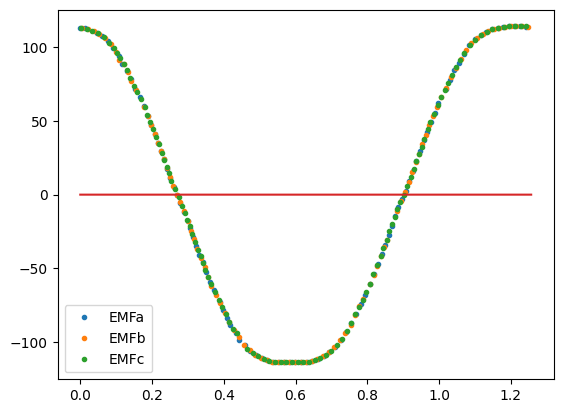

In [318]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.deg2rad(df['EMFa']['X'] % 72), df['EMFa']['Y'], '.' ,label='EMFa')
ax.plot(np.deg2rad((df['EMFb']['X']-24) % 72), df['EMFb']['Y'], '.', label='EMFb')
ax.plot(np.deg2rad((df['EMFc']['X']+24) % 72), df['EMFc']['Y'], '.', label='EMFc')
ax.legend()
p = 5
n_coef = 2
x = np.linspace(0, 2*np.pi/p, 360)
x = np.reshape(x, (1, -1))
coef=np.array([float(i%2)*100 for i in range(n_coef+1) ])
coef[0] = 0.04

def err(coef):
    xx = np.reshape(np.deg2rad(df['EMFa']['X'] % 72), (1, -1))
    yy = np.diag(coef[1: ]) * np.cos(p*np.dot(np.matrix(range(1, n_coef+1, 1)).T, (xx + coef[0])))
    
    err = (np.array(np.sum(yy, axis=0))**2 - df['EMFa']['Y'].values**2)
    
    return(np.nanmean(err))

def evalme(coef, xx):
    yy = np.diag(coef[1: ]) * np.cos(p*np.dot(np.matrix(range(1, n_coef+1, 1)).T, (xx + coef[0])))
    
    return(np.sum(yy, axis=0))
    
from scipy.optimize import minimize
res = minimize(err, coef, method='Nelder-Mead', tol=1e-6)

print(res)
 
ax.plot(x.T, evalme(res.x, x).T, label='Fitted')



In [319]:

evalme(res.x, x)


matrix([[ 2.48437499e-03,  2.43773303e-03,  2.38813385e-03,
          2.33563808e-03,  2.28030987e-03,  2.22221687e-03,
          2.16143006e-03,  2.09802376e-03,  2.03207544e-03,
          1.96366573e-03,  1.89287823e-03,  1.81979944e-03,
          1.74451869e-03,  1.66712798e-03,  1.58772188e-03,
          1.50639743e-03,  1.42325402e-03,  1.33839325e-03,
          1.25191881e-03,  1.16393637e-03,  1.07455345e-03,
          9.83879241e-04,  8.92024547e-04,  7.99101592e-04,
          7.05223904e-04,  6.10506174e-04,  5.15064115e-04,
          4.19014318e-04,  3.22474116e-04,  2.25561430e-04,
          1.28394636e-04,  3.10924102e-05, -6.62264095e-05,
         -1.63442972e-04, -2.60438559e-04, -3.57094728e-04,
         -4.53293458e-04, -5.48917298e-04, -6.43849502e-04,
         -7.37974182e-04, -8.31176442e-04, -9.23342524e-04,
         -1.01435994e-03, -1.10411763e-03, -1.19250605e-03,
         -1.27941738e-03, -1.36474559e-03, -1.44838659e-03,
         -1.53023837e-03, -1.61020112e-0

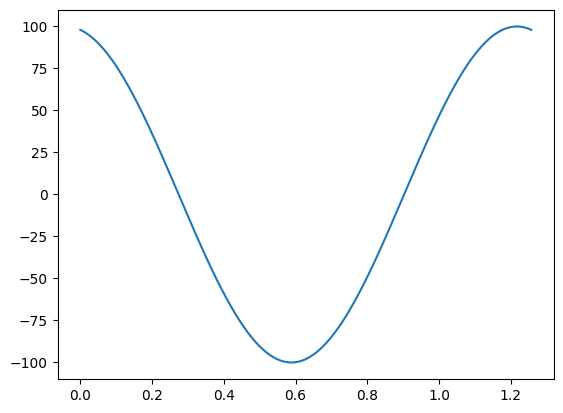

In [320]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x.T, evalme(coef, x).T, label='Fitted')

In [85]:
360/5

72.0

In [63]:
import numpy as np
emfa(40)

array(nan)

In [65]:
df['EMFa']['X'].max()

72.73834586466167